# Stanford - 96 codes - Jupyter example
title             : Stanford - 96 codes - Jupyer example.nbpy [filename]
description       : Multi file - Stanford Setup
author            : Bjorn Harink                              [Original author(s) of this file]
credits           : Kurt Thorn, Huy Nguyen                    [Contributors to this file]
date              : 20170220                                  [Initial date yyyymmdd]
version update    : 20170220                                  [Last version update yyyymmdd]
version           : v0.1
usage             : This is an example file for the Bead Analysis module.
notes             : Multiple file code set for Stanford setup - Jupyter Notebook
python_version    : 2.7

# Import modules and bead analysis tools

In [22]:
# [Future imports]
# "print" function compatibility between Python 2.x and 3.x
from __future__ import print_function
# Use Python 3.x "/" for division in Pyhton 2.x
from __future__ import division

# [Modules]
# General Python
import sys
sys.path.append('../')  # Or wherever your Bead Analysis module folder is
import random
# Data structures
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
# Image Processing
# Project
import mrbles

# Image display/notebook settings
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib notebook
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Global Settings

In [9]:
# Reference image location
REF_FILES = {"Dy" : r"Z:\Data\Setup 1\Bead Reference Files\20170406 - Reference files - KARA\Dy_Solos_3_MMStack_Pos0.ome.tif",
             "Sm" : r"Z:\Data\Setup 1\Bead Reference Files\20170406 - Reference files - KARA\Sm_solos_5_MMStack_Pos0.ome.tif",
             "Tm" : r"Z:\Data\Setup 1\Bead Reference Files\20170406 - Reference files - KARA\Tm_solos_3_MMStack_Pos0.ome.tif",
             "Eu" : r"Z:\Data\Setup 1\Bead Reference Files\20170406 - Reference files - KARA\Eu_solos_6_MMStack_Pos0.ome.tif"}

# Target file location
TARGET_FILE = r"Z:\General\CodeSets\20160226_DySmTm_48Codes.csv"

#########################
###   Targets/Codes   ###
"""[NOTES - Target File]
The target file contains the code ratios and are stored 
in a csv file with makeup [CeTb, Dy, Sm, Tm], e.g.:
>>> target
array([[ 0.20061,  0.08155,  0.     ,  0.65606],
       [ 0.     ,  0.08155,  0.10822,  0.     ],
       [ 0.     ,  0.08155,  0.10822,  0.19141],
       ...
"""

target = np.genfromtxt(TARGET_FILE, delimiter=',')
target = target[:, 1:4]  # Target set to Dy, Sm, Tm (no CeTb)

# Bead search and filter parameters
bead_objects = mrbles.FindBeadsImaging(bead_size=12)
reference_std_factor_low = 2
reference_std_factor_high = 2
back_std_factor = 2

# ICP settings
icp=mrbles.ICP(matrix_method='std', max_iter=100, tol=1e-4, outlier_pct=0.01, train=False)

# GMM settings
gmix = mrbles.Classify(target, tol=1e-5, min_covar=1e-7, sigma=1e-5, train=False)

# Reference Spectra

Spectrum: Dy
No beads: 166
Spectrum: Sm
No beads: 315
Spectrum: Tm
No beads: 199
Spectrum: Eu
No beads: 95
Spectrum Bkg: slice(312, 712, None), slice(312, 712, None)


<IPython.core.display.Javascript object>


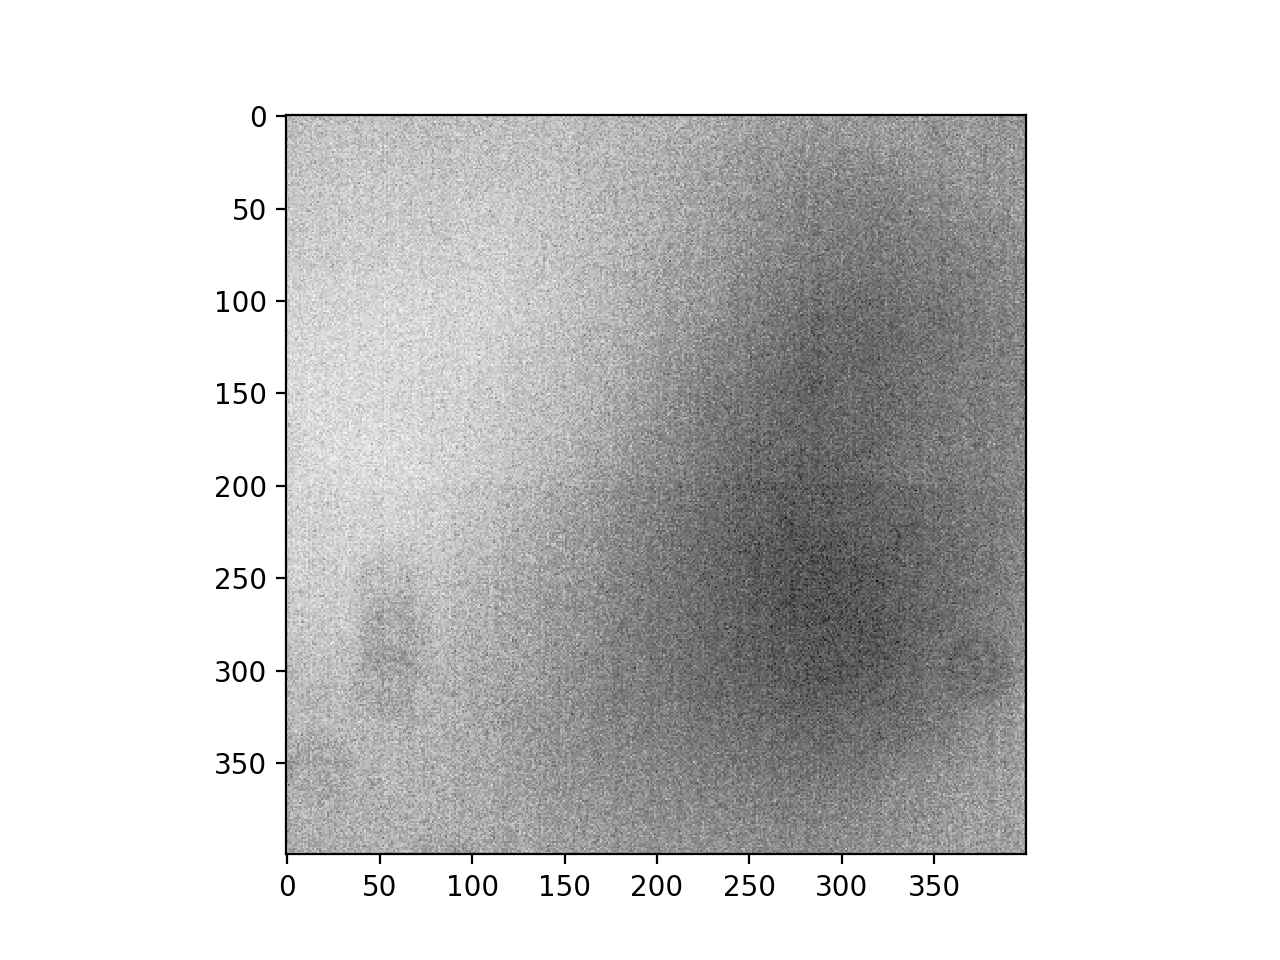

G:\My Drive\[Stanford]\DEV\Encoded Beads Project\Bead Analysis\mrbles\data.py:336: UserWarning:

Channel names not the same or channels unchecked!



In [11]:
# Background image set file location
BACK_FILE = r"Z:\Data\Setup 1\Bead Reference Files\20170406 - Reference files - KARA\20170320_blank_1_MMStack_Pos0.ome.tif"

# Reference images ROI
CROPx_ref = slice(312, 712)
CROPy_ref = slice(312, 712)

# Background ROI
BACK_ROIx = slice(312, 712)
BACK_ROIy = slice(312, 712)

dark_noise = 99  # Camera dark noise
spec_object = mrbles.pipeline.ReferenceSpectra(bead_size = 16,
                                               files = REF_FILES, 
                                               object_channel = 'Brightfield', 
                                               channels = ['l-435','l-780'], 
                                               dark_noise = dark_noise)
spec_object.crop_x = CROPx_ref
spec_object.crop_y = CROPx_ref
spec_object.get_spectra()
spec_object.set_back(BACK_FILE, ['l-435','l-780'], BACK_ROIx, BACK_ROIy)
ref_data_object = spec_object.output

<IPython.core.display.Javascript object>


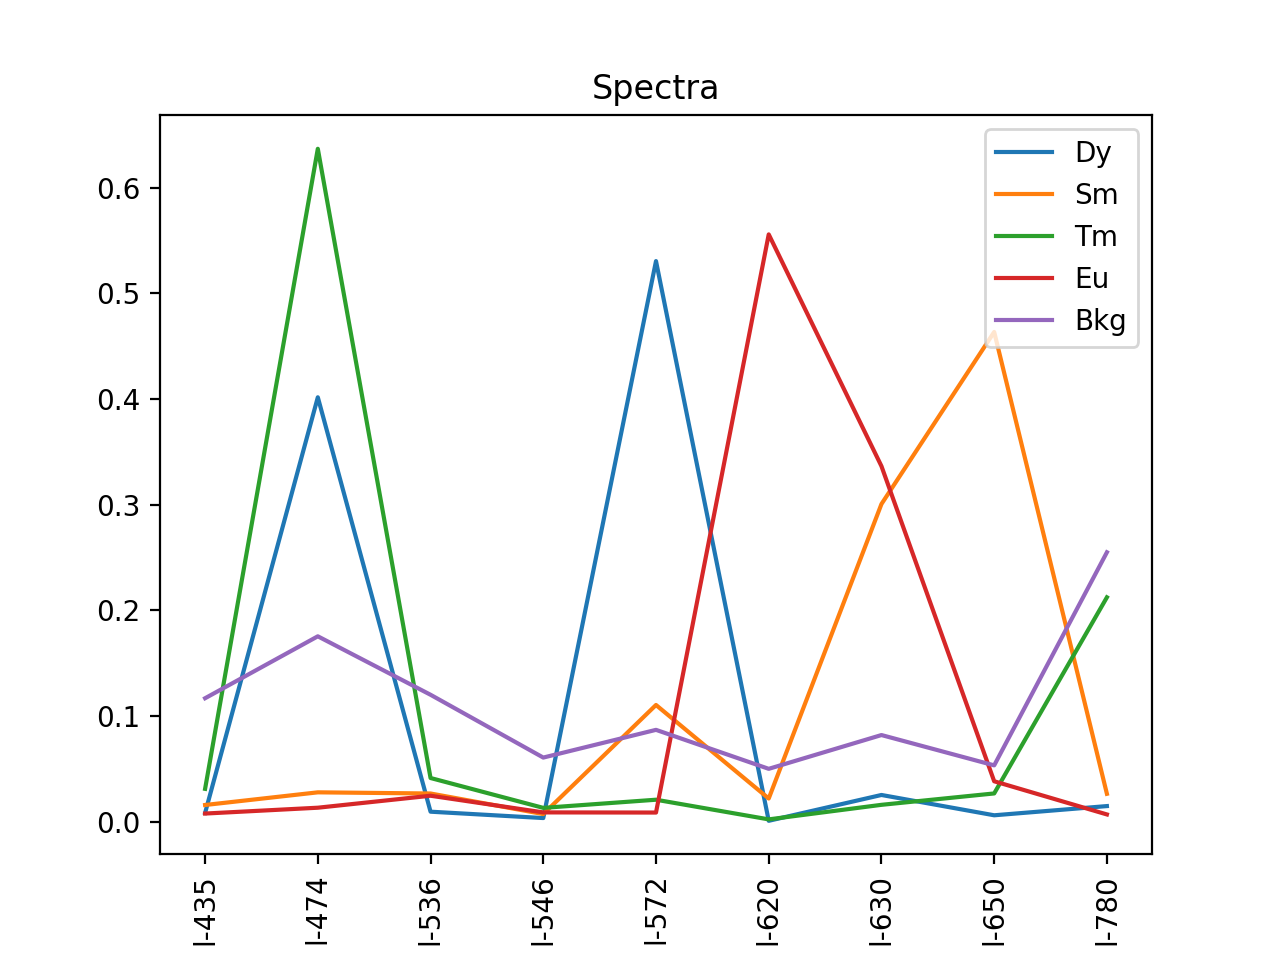

In [12]:
ref_data_object.plot()

# Load image files and detect objects
Initiated bead_set data

In [13]:
# Bead image set file location
BEAD_IMAGE_FOLDER = r"Z:\Data\Setup 1\Huy\20170726 CN PxI2"
BEAD_IMAGE_PATTERN = "20170726_HQN_CN_PxI2_1Step_1uM_([1-9]|[1-9][0-9])_MMStack_Pos0.ome.tif"

bead_image_files = mrbles.ImageSetRead.scan_path(BEAD_IMAGE_FOLDER, BEAD_IMAGE_PATTERN)
bead_image_obj = mrbles.ImageSetRead(bead_image_files)
bead_image_set_bf = bead_image_obj[:,'Brightfield',CROPy,CROPx]
bead_image_set_ln = bead_image_obj[:,'l-435':'l-780',CROPy,CROPx]

In [19]:
bead_set = pd.DataFrame(columns=['img', 
                                 'lbl', 
                                 'dim_x', 
                                 'dim_y', 
                                 'dim_r',
                                 'bkg',
                                 'ref',
                                 'rat_dy',
                                 'rat_sm',
                                 'rat_tm'])

labels = []
labels_annulus = []
bead_no = 0
for idx in range(bead_image_obj.f_size):
    bead_objects.find(bead_image_set_bf[idx])
    if bead_objects.bead_num <= 1:
        continue
    labels.append(bead_objects.mask("mask_inside"))
    labels_annulus.append(bead_objects.mask("mask_inside"))
    circles_dim = np.array(bead_objects.bead_dims)
    for lbl in np.arange(1, len(np.unique(labels[idx]))):
        bead_set.loc[bead_no,('img', 'lbl', 'dim_x', 'dim_y', 'dim_r')] = \
            [idx, lbl, circles_dim[lbl-1, 0], circles_dim[lbl-1, 1], circles_dim[lbl-1, 2]]
        bead_no += 1
        
print("Total number of beads found: %s" % bead_no)

Total number of beads found: 985


# Unmix and get Ratios

In [23]:
spec_unmix = mrbles.SpectralUnmixing(ref_data_object)
bead_no = 0
for lbls_idx, lbls in enumerate(labels):
    spec_unmix.unmix(bead_image_set_ln[lbls_idx])

    background = spec_unmix['Bkg']  # Device background
    reference = spec_unmix['Eu']  # Internal reference: Eu
    # Ratio images
    ratio_Dy = spec_unmix['Dy'] / reference
    ratio_Sm = spec_unmix['Sm'] / reference
    ratio_Tm = spec_unmix['Tm'] / reference
    # Get ratios from images
    idx = np.arange(1, len(np.unique(lbls)))
    ratio_data = np.empty((len(idx), target[0].size))
    ratio_data[:, 0] = ndi.labeled_comprehension(ratio_Dy, lbls, idx, np.median, float, -1)
    ratio_data[:, 1] = ndi.labeled_comprehension(ratio_Sm, lbls, idx, np.median, float, -1)
    ratio_data[:, 2] = ndi.labeled_comprehension(ratio_Tm, lbls, idx, np.median, float, -1)

    background_data = ndi.labeled_comprehension(background, lbls, idx, np.median, float, -1)
    reference_data = ndi.labeled_comprehension(reference, lbls, idx, np.median, float, -1)

    for lbl in np.arange(1, len(np.unique(lbls))):
        bead_set.loc[bead_no,('rat_dy', 'rat_sm', 'rat_tm', 'bkg', 'ref')] = \
            [ratio_data[lbl-1,0], ratio_data[lbl-1,1], ratio_data[lbl-1,2], background_data[lbl-1], reference_data[lbl-1]]
        bead_no += 1

In [24]:
bead_set

,img,lbl,dim_x,dim_y,dim_r,bkg,ref,rat_dy,rat_sm,rat_tm
0,0,1,6,378.601,44.2681,-1,-1,-1,-1,-1
1,0,2,11,72.5891,98.8915,-1,-1,-1,-1,-1
2,0,3,13,434.956,106.481,-1,-1,-1,-1,-1
3,0,4,16,470.333,156.5,-1,-1,-1,-1,-1
4,0,5,17,466.5,175.908,-1,-1,-1,-1,-1
5,0,6,18,280.992,188.74,1378.27,8478,1.13981,0.947928,0.0400867
6,0,7,24,389.496,324.298,-1,-1,-1,-1,-1
7,1,1,5,327.341,33.6,-1,-1,-1,-1,-1
8,1,2,6,119.546,34.5502,-1,-1,-1,-1,-1
9,1,3,10,469.439,63.8258,-1,-1,-1,-1,-1


# Filtering

In [26]:
mask_bkg    = ( (bead_set.bkg > (bead_set.bkg.mean() - back_std_factor * bead_set.bkg.std())) &\
                (bead_set.bkg < (bead_set.bkg.mean() + back_std_factor * bead_set.bkg.std())) )
mask_ref    = ( (bead_set.ref > (bead_set.ref.mean() - reference_std_factor_low * bead_set.ref.std())) &\
                (bead_set.ref < (bead_set.ref.mean() + reference_std_factor_high * bead_set.ref.std())) )
filter_all = (mask_bkg & mask_ref)

print("Pre filter: %s" % bead_set.index.size)
print("Post filter: %s" % bead_set[filter_all].index.size)

# Pre-filter images
img_idx = []
for x in range(3):
    idx = random.choice(np.unique(bead_set.img))
    img_idx.append(idx)
    fig = plt.figure()
    ax = fig.add_subplot(1,2,1)
    ax.axis('off')
    fig.suptitle("Overlay Image Pre-filter image #: %s" % idx)
    ax.imshow(bead_objects.overlay_image(bead_image_set_bf[idx], 
                                          dim=bead_set.loc[(bead_set['img'] == idx), ('dim_x','dim_y','dim_r')].values,
                                          annulus=True), cmap='Greys_r')
    ax = fig.add_subplot(1,2,2)
    ax.axis('off')
    ax.imshow(bead_objects.overlay_image(bead_image_set_bf[idx], 
                                          dim=bead_set.loc[filter_all & (bead_set['img'] == idx), ('dim_x','dim_y','dim_r')].values,
                                          annulus=True), cmap='Greys_r')

Pre filter: 985
Post filter: 928


KeyboardInterrupt: 

# ICP

In [27]:
icp.fit(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')], target)
bead_set = bead_set.join(icp.transform())
print("Tranformation matrix: ", icp.matrix)
print("Offset vector: ", icp.offset)

Delta:  1.66294772802
Delta:  0.0488120946867
Delta:  0.0244814334456
Delta:  0.0357054756545
Delta:  0.0324207095154
Delta:  0.0128847255912
Delta:  0.0214115653326
Delta:  0.0225704601489
Delta:  0.0185448132194
Delta:  0.00721736406597
Delta:  0.0103668147117
Delta:  0.0155784084276
Delta:  0.0289519835329
Delta:  0.0181686504238
Delta:  0.0130896950593
Delta:  0.0125189033595
Delta:  0.00205895324423
Delta:  0.00405563691927
Delta:  0.00786013447266
Delta:  0.00603497680888
Delta:  0.00169270768661
Delta:  0.00597943869276
Delta:  0.0150525959632
Delta:  0.00868878200508
Delta:  0.00834621446782
Delta:  0.0105442858255
Delta:  0.01069019399
Delta:  0.00207979393402
Delta:  0.00208610325408
Delta:  0.00373358181485
Delta:  0.0100428230231
Delta:  0.00647976435918
Delta:  0.00570217917326
Delta:  0.00749310408274
Delta:  0.00238470028871
Delta:  0.00154666868798
Delta:  0.0
Converged after: 37
Tranformation matrix:  [[ 0.06098733 -0.09899026 -0.11304256]
 [-0.05380087  0.12385324 -0.

# Classification

In [28]:
gmix.decode(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')])
bead_set = bead_set.join(gmix.output)
print("Number of unique codes found:", gmix.found)
print("Missing codes:", gmix.missing)

Number of unique codes found: 15
Missing codes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 16 17 18 19 20 21 22 23 29 30 31 32
 38 40 42 43 44 45 46 47]


## Data inspection charts
Notes...

In [29]:
# Clustering pre-ICP & Pre-filter
mrbles.inspect.Cluster.scatter(bead_set.loc[:, ('rat_dy', 'rat_sm', 'rat_tm')].values, 
                           target, 
                           title="Clustering pre-ICP & Pre-filter", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering pre-ICP & Filtered
mrbles.inspect.Cluster.scatter(bead_set.loc[filter_all, ('rat_dy', 'rat_sm', 'rat_tm')].values, 
                           target, 
                           bead_set.loc[filter_all, ('code')].values, 
                           title="Clustering pre-ICP & Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering post-ICP & Filtered
mrbles.inspect.Cluster.scatter(bead_set.loc[filter_all, ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].values, 
                           target, 
                           bead_set.loc[filter_all, ('code')].values, 
                           title="Clustering post-ICP & Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])
# Clustering post-ICP & Filtered & Confidence Filtered
mrbles.inspect.Cluster.scatter(bead_set.loc[(bead_set.confidence > 0), ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].values, 
                           target, 
                           bead_set.loc[(bead_set.confidence > 0), ('code')].values, 
                           title="Clustering post-ICP & Filtered & Confidence Filtered", 
                           axes_names=['Dy', 'Sm', 'Tm'])

# Single code chart
code_no = 21 # Starts at 0!
code_data = np.vstack(bead_set.loc[(bead_set.code == code_no), ('rat_dy_icp', 'rat_sm_icp', 'rat_tm_icp')].as_matrix())
mrbles.inspect.Cluster.scatter(code_data, target, title="Clustering post-ICP", axes_names=['Dy', 'Sm', 'Tm'])

# Size dist
plt.figure()
bead_set.loc[filter_all, ('dim_r')].hist(bins=10)

# Beads per code distribution
plt.figure()
plt.hist(bead_set.loc[filter_all, ('code')])

<IPython.core.display.Javascript object>

ValueError: Unknown projection '3d'

## Scatter charts

In [ ]:
confidence = 0
colors = np.multiply(bead_set.code.loc[(bead_set.confidence > confidence)].values, np.ceil(255/gmix._nclusters))

bead_ratios = go.Scatter3d(
    name='Bead ratios',
    x=bead_set.loc[(bead_set.confidence > confidence), ('rat_dy_icp')].values,
    y=bead_set.loc[(bead_set.confidence > confidence), ('rat_sm_icp')].values,
    z=bead_set.loc[(bead_set.confidence > confidence), ('rat_tm_icp')].values,
    text=bead_set.loc[(bead_set.confidence > confidence), ('code')].values,
    mode='markers',
    marker=dict(
        size=3,
        color=colors, 
        colorscale='Rainbow',
        opacity=0.6
    )
)

target_ratios = go.Scatter3d(
    name='Target ratios',
    x=target[:,0],
    y=target[:,1],
    z=target[:,2],
    text=range(gmix._nclusters),
    mode='markers',
    marker=dict(
        size=4,
        color='Black',
        opacity=0.5,
        symbol="diamond"
    )
)

mean_ratios = go.Scatter3d(
    name='GMM mean ratios',
    x=gmix.means[:,0],
    y=gmix.means[:,1],
    z=gmix.means[:,2],
    text=range(gmix._nclusters),
    mode='markers',
    marker=dict(
        size=4,
        color='Red',
        opacity=0.5,
        symbol="diamond"
    )
)

data = [bead_ratios, target_ratios, mean_ratios]
layout = go.Layout(
    showlegend=True,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='3d-scatter-colorscale')